# EEGNet Classification for P1

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import mplcursors
import mne

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from EEGModels import EEGNet
from tensorflow.keras.models import load_model

# Set seeds for reproducibility
np.random.seed(2024)
tf.random.set_seed(2024)

## Define participant and paths

In [2]:
participant = '1'

In [16]:
base_path = f'/Users/helen/Documents/Bachelorarbeit/Data/P{participant}'
plot_dir = os.path.join(base_path, f'P{participant}_runs_plots')
checkpoint_dir = os.path.join(base_path, 'model_checkpoints')
scores_file_path = os.path.join(plot_dir, "scores.txt")

# Create directories if they do not exist
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Create an empty scores file if it does not exist
if not os.path.isfile(scores_file_path):
    open(scores_file_path, 'w').close()

## Functions

### Load and Preprocess

In [4]:
def load_and_preprocess_epochs(participant):
    liked_path = f'/Users/helen/Downloads/P{participant}_training_liked_epochs-epo.fif'
    disliked_path = f'/Users/helen/Downloads/P{participant}_training_disliked_epochs-epo.fif'
    test_liked_path = f'/Users/helen/Downloads/P{participant}_test_liked_epochs-epo.fif'
    test_disliked_path = f'/Users/helen/Downloads/P{participant}_test_disliked_epochs-epo.fif'

    epochs_paths = [liked_path, disliked_path, test_liked_path, test_disliked_path]
    epochs = [mne.read_epochs(path, preload=True).resample(128, npad='auto') for path in epochs_paths]
    return epochs

### Extract and standardize data

In [5]:
def extract_and_standardize_data(epochs):
    training_liked, training_disliked, test_liked, test_disliked = epochs

    # Scale data
    scale_factor = 1000
    data = [ep.get_data() * scale_factor for ep in [training_liked, training_disliked, test_liked, test_disliked]]
    
    # Combine data and labels
    training_data = np.concatenate(data[:2], axis=0)
    test_data = np.concatenate(data[2:], axis=0)
    training_labels = np.concatenate([np.ones(len(data[0])), np.zeros(len(data[1]))], axis=0)
    test_labels = np.concatenate([np.ones(len(data[2])), np.zeros(len(data[3]))], axis=0)

    # Standardize data
    mean = np.mean(training_data, axis=(0, 2))
    std = np.std(training_data, axis=(0, 2))
    training_data_standardized = (training_data - mean[:, np.newaxis]) / std[:, np.newaxis]
    test_data_standardized = (test_data - mean[:, np.newaxis]) / std[:, np.newaxis]

    # Convert labels to one-hot encoding
    num_classes = 2
    training_labels_one_hot = np.eye(num_classes)[training_labels.astype(int)]
    test_labels_one_hot = np.eye(num_classes)[test_labels.astype(int)]

    return training_data_standardized, test_data_standardized, training_labels_one_hot, test_labels_one_hot

## Model Functions

#### Extract Hyperparameters from Parameter Dictionary

In [6]:
def extract_params(params):
    return (
        params['batch_size'],
        params['learning_rate'],
        params['epochs'],
        params['optimizer'],
        params['kernel_regularizer_value'],
        params['depthwise_regularizer_value'],
        params['dropout_rate']
    )

#### Train the Model with Given Hyperparameters and Save Best Model Weights

In [7]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, checkpoint_filepath):
    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True)
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_val, y_val),
        callbacks=[
            checkpoint,
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1),
            EarlyStopping(monitor='val_loss', patience=75, verbose=1, mode='min', restore_best_weights=True)
        ]
    )
    return history

#### Save Evaluation Results to a Text File

In [8]:
def save_scores(file_path, run, fold_no, params, loss, accuracy):
    with open(file_path, "a") as file:
        file.write(f"=== Run {run+1} Fold {fold_no} ===\n")
        file.write(f"Parameters: {params}\n")
        file.write(f"Validation Loss: {loss}\n")
        file.write(f"Validation Accuracy: {accuracy}\n\n")

#### Plot and Save Training and Validation Loss/Accuracy History

In [9]:
def plot_history(history, run, fold_no, path, params):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Run {run+1} Fold {fold_no} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Run {run+1} Fold {fold_no} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plot_file_path = os.path.join(path, f"train_hist_run{run+1}_fold{fold_no}_bs{params['batch_size']}_lr{params['learning_rate']}_ep{params['epochs']}_drate_{params['dropout_rate']}_dreg_{params['depthwise_regularizer_value']}_kreg_{params['kernel_regularizer_value']}_opt_{params['optimizer']}.png")
    plt.savefig(plot_file_path)
    plt.close()


#### Evaluate models on Training data

In [10]:
def evaluate_models(param_grid, n_runs=3, random_states=[11, 4, 71], participant='1'):
    
    for params in param_grid:
        batch_size, learning_rate, epochs, optimizer_name, kernel_regularizer_value, depthwise_regularizer_value, dropout_rate = extract_params(params)
        kernel_regularizer = l2(kernel_regularizer_value)
        depthwise_regularizer = l2(depthwise_regularizer_value)

        grand_loss_per_fold = []
        grand_accuracy_per_fold = []

        for run in range(n_runs):
            print(f"=== Run {run+1} ===")
            kf = KFold(n_splits=5, shuffle=True, random_state=random_states[run])
            loss_per_fold = []
            accuracy_per_fold = []

            for fold_no, (train_index, val_index) in enumerate(kf.split(training_data_standardized, training_labels_one_hot), 1):
                X_train, X_val = training_data_standardized[train_index], training_data_standardized[val_index]
                y_train, y_val = training_labels_one_hot[train_index], training_labels_one_hot[val_index]

                model = EEGNet(
                    nb_classes=2,
                    Chans=8,
                    Samples=256,
                    dropoutRate=dropout_rate,
                    kernLength=64,
                    F1=8,
                    D=2,
                    F2=16,
                    norm_rate=0.25,
                    dropoutType='Dropout',
                    kernel_regularizer=kernel_regularizer,
                    depthwise_regularizer=depthwise_regularizer
                )
                optimizer = Adam(learning_rate=learning_rate)
                model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

                filepath = os.path.join(checkpoint_dir, f'run_{run+1}_fold_{fold_no}_bs_{batch_size}_lr_{learning_rate}_ep_{epochs}_drate_{dropout_rate}_dreg_{depthwise_regularizer_value}_kreg_{kernel_regularizer_value}_opt_{optimizer_name}.keras')
                history = train_model(model, X_train, y_train, X_val, y_val, batch_size, epochs, filepath)

                loss, accuracy = model.evaluate(X_val, y_val)
                print(f'Validation loss for Fold {fold_no}: {loss}')
                print(f'Validation accuracy for Fold {fold_no}: {accuracy}')
                loss_per_fold.append(loss)
                accuracy_per_fold.append(accuracy)

                plot_history(history, run, fold_no, plot_dir, params)
                save_scores(scores_file_path, run, fold_no, params, loss, accuracy)

            grand_loss_per_fold.extend(loss_per_fold)
            grand_accuracy_per_fold.extend(accuracy_per_fold)

        with open(scores_file_path, "a") as file:
            file.write(f"=== Run {run+1} ===\n")
            file.write(f"Parameters: {params}\n")
            file.write(f"Average Accuracy: {np.mean(grand_accuracy_per_fold)} (+- {np.std(grand_accuracy_per_fold)})\n")
            file.write(f"Average Loss: {np.mean(grand_loss_per_fold)}\n\n")

### Evaluation on test data

#### Bar chart

In [26]:
def evaluate_and_visualize_models(checkpoint_dir, test_data_standardized, test_labels_one_hot):
    
    # Get a list of model files in the folder
    model_files_filt = [f for f in os.listdir(checkpoint_dir) if f.endswith('.keras')]

    # Initialize list to store evaluation results
    results = []

    # Evaluate each model
    for model_file in model_files_filt:
        # Load the model
        model_path = os.path.join(checkpoint_dir, model_file)
        model = tf.keras.models.load_model(model_path)
        
        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_data_standardized, test_labels_one_hot, verbose=0)
        
        # Store results
        results.append({'model': model_file, 'loss': test_loss, 'accuracy': test_accuracy})

    # Convert results to a Pandas DataFrame for easier analysis and visualization
    results_df = pd.DataFrame(results)

    # Find the model with the highest accuracy
    best_model = results_df.loc[results_df['accuracy'].idxmax()]

    # Display the best model's filename and its accuracy
    print(f"Best model: {best_model['model']} with accuracy: {best_model['accuracy']}")

    # Display the results
    print(results_df)

    # Visualize the results using a bar plot
    sns.barplot(x='accuracy', y='model', data=results_df.sort_values('accuracy', ascending=False))
    plt.xlabel('Accuracy')
    plt.ylabel('Model')
    plt.title('Model Performance on Test Set')

    # Activate hover interactions with mplcursors
    mplcursors.cursor(hover=True)

    # Show the plot
    plt.show()

    return best_model

#### Confusion matrix

In [12]:
def evaluate_best_model(best_model, checkpoint_dir, test_data_standardized, test_labels_one_hot):
    
    # Load the best model
    best_model_path = os.path.join(checkpoint_dir, best_model['model'])
    model = load_model(best_model_path)

    # Predict on the test dataset
    predictions = model.predict(test_data_standardized)

    # Convert predictions from probabilities to class labels
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels_one_hot, axis=1)

    # Calculate evaluation metrics
    cm = confusion_matrix(true_classes, predicted_classes)
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='macro')
    recall = recall_score(true_classes, predicted_classes, average='macro')
    f1 = f1_score(true_classes, predicted_classes, average='macro')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Visualize confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

## Execution

In [14]:
epochs = load_and_preprocess_epochs(participant)

training_data_standardized, test_data_standardized, training_labels_one_hot, test_labels_one_hot = extract_and_standardize_data(epochs)

# Define parameter grid
param_grid = [
    {
        'batch_size': [11],
        'learning_rate': [0.00005],
        'epochs': [200],
        'optimizer': ['Adam'],
        'kernel_regularizer_value': [0.05],
        'depthwise_regularizer_value': [0.05],
        'dropout_rate': [0.65]
    }
]
grid = ParameterGrid(param_grid)
evaluate_models(grid)

Reading /Users/helen/Downloads/P1_training_liked_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
117 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/helen/Downloads/P1_training_disliked_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
117 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/helen/Downloads/P1_test_liked_epochs-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    1996.00 ms
        0 CTF compensation matrices available
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/helen/Downloads/P1_test_disliked_epochs-epo.fif ...

/var/folders/07/1x78f4tj5h751d_bvqhvdg480000gn/T/ipykernel_93848/1931474103.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [ep.get_data() * scale_factor for ep in [training_liked, training_disliked, test_liked, test_disliked]]
/var/folders/07/1x78f4tj5h751d_bvqhvdg480000gn/T/ipykernel_93848/1931474103.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [ep.get_data() * scale_factor for ep in [training_liked, training_disliked, test_liked, test_disliked]]
/var/folders/07/1x78f4tj5h751d_bvqhvdg480000gn/T/ipykernel_93848/1931474103.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = [ep.get_data() * scale_factor for ep in [training_liked, training_disliked, test_liked, test_disliked]]
/var

17/17 - 1s - 46ms/step - accuracy: 0.4545 - loss: 1.0584 - val_accuracy: 0.5532 - val_loss: 1.0346 - learning_rate: 5.0000e-05
Epoch 2/200
17/17 - 0s - 6ms/step - accuracy: 0.5241 - loss: 1.0362 - val_accuracy: 0.5319 - val_loss: 1.0322 - learning_rate: 5.0000e-05
Epoch 3/200
17/17 - 0s - 6ms/step - accuracy: 0.4599 - loss: 1.0400 - val_accuracy: 0.5532 - val_loss: 1.0297 - learning_rate: 5.0000e-05
Epoch 4/200
17/17 - 0s - 5ms/step - accuracy: 0.5294 - loss: 1.0287 - val_accuracy: 0.5532 - val_loss: 1.0271 - learning_rate: 5.0000e-05
Epoch 5/200
17/17 - 0s - 5ms/step - accuracy: 0.4866 - loss: 1.0238 - val_accuracy: 0.5319 - val_loss: 1.0245 - learning_rate: 5.0000e-05
Epoch 6/200
17/17 - 0s - 5ms/step - accuracy: 0.4920 - loss: 1.0286 - val_accuracy: 0.5319 - val_loss: 1.0219 - learning_rate: 5.0000e-05
Epoch 7/200
17/17 - 0s - 6ms/step - accuracy: 0.4545 - loss: 1.0227 - val_accuracy: 0.5106 - val_loss: 1.0193 - learning_rate: 5.0000e-05
Epoch 8/200
17/17 - 0s - 6ms/step - accuracy:

## Evaluation on test data

Best model: run_3_fold_5_bs_11_lr_5e-05_ep_200_drate_0.65_dreg_0.05_kreg_0.05_opt_Adam.keras with accuracy: 0.5256410241127014
                                                model      loss  accuracy
0   run_2_fold_5_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.901054  0.294872
1   run_2_fold_2_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.823718  0.397436
2   run_3_fold_4_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.991479  0.320513
3   run_3_fold_3_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.793147  0.512821
4   run_1_fold_2_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.765295  0.512821
5   run_1_fold_5_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.915940  0.269231
6   run_3_fold_1_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.820605  0.435897
7   run_2_fold_4_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.872336  0.397436
8   run_2_fold_3_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.887457  0.448718
9   run_2_fold_1_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.790757  0.487179
10  run_1_fold_3_bs_11_lr_5e-05_ep_200_drate_0.65_...  0.85

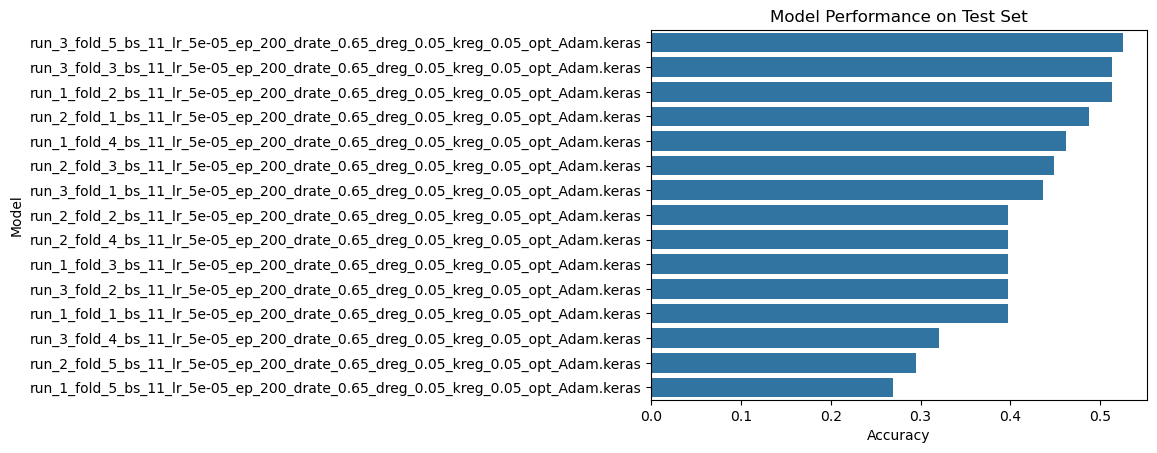

In [30]:
best_model = evaluate_and_visualize_models(checkpoint_dir, test_data_standardized, test_labels_one_hot)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5256410256410257
Precision: 0.5260695187165776
Recall: 0.5256410256410257
F1 Score: 0.5236837762006932


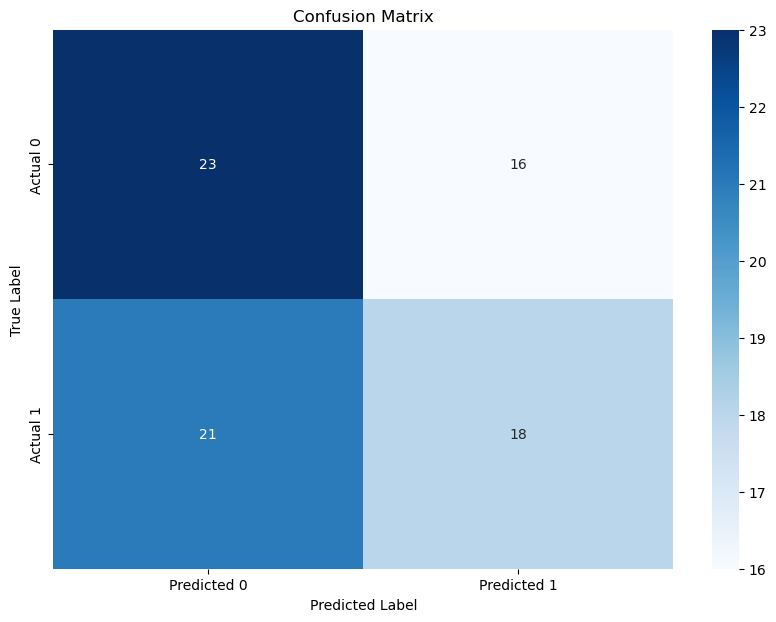

In [31]:
evaluate_best_model(best_model, checkpoint_dir, test_data_standardized, test_labels_one_hot)